In [14]:
import os
import psycopg2
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Test connection
try:
    conn = psycopg2.connect(os.getenv("DATABASE_URL"))
    cursor = conn.cursor()
    cursor.execute("SELECT version();")
    print("✓ Connected to:", cursor.fetchone()[0])
    cursor.close()
    conn.close()
except Exception as e:
    print("✗ Connection failed:", e)


✓ Connected to: PostgreSQL 17.6 on aarch64-unknown-linux-gnu, compiled by gcc (GCC) 13.2.0, 64-bit


In [15]:
import sys
print(sys.executable)

c:\Users\kdevu\AppData\Local\Programs\Python\Python312\python.exe


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Reusable connection function — called once per cell instead of
# repeating psycopg2.connect(...) everywhere. If the URL changes, fix it here.
def get_connection():
    return psycopg2.connect(os.getenv("DATABASE_URL"))

# Global chart styling — set once, applies to every chart below.
# figsize     : default chart size in inches (width x height)
# spines      : remove top and right border lines for a cleaner look
# grid        : light horizontal gridlines to help read values
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.4

print("✓ Setup complete")

✓ Setup complete


C:\Users\kdevu\AppData\Local\Temp\ipykernel_16380\3548521965.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, parse_dates=["month"])


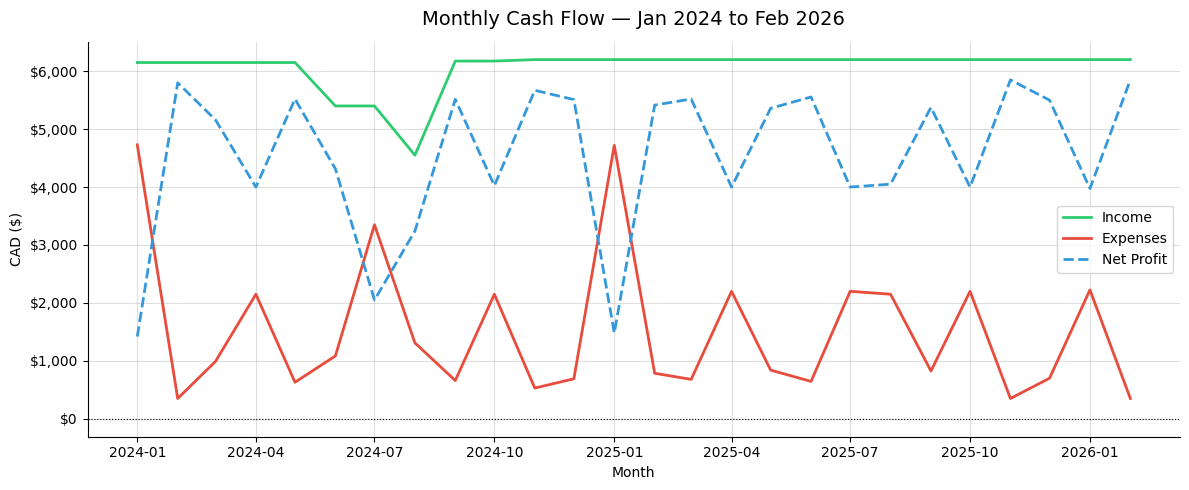

In [17]:
# ── Query 1: Monthly Cash Flow ───────────────────────────────────────
# Pull income, expenses, and net profit for every month in the dataset.
# pd.read_sql() runs the query and returns the result as a DataFrame —
# basically a table in Python we can then plot directly.
# parse_dates converts the month column from a string to a proper datetime
# so Matplotlib can space the x-axis correctly by date.

query = """
    WITH monthly_income AS (
        SELECT
            DATE_TRUNC('month', payment_date) AS month,
            SUM(amount)                       AS total_income
        FROM payments
        WHERE status IN ('on_time', 'late')
        GROUP BY 1
    ),
    monthly_expenses AS (
        SELECT
            DATE_TRUNC('month', expense_date) AS month,
            SUM(amount)                       AS total_expenses
        FROM expenses
        GROUP BY 1
    )
    SELECT
        COALESCE(i.month, e.month)                                    AS month,
        COALESCE(i.total_income, 0)                                   AS total_income,
        COALESCE(e.total_expenses, 0)                                 AS total_expenses,
        COALESCE(i.total_income, 0) - COALESCE(e.total_expenses, 0)  AS net_profit
    FROM       monthly_income    AS i
    FULL OUTER JOIN monthly_expenses AS e ON i.month = e.month
    ORDER BY month
"""

conn = get_connection()
df = pd.read_sql(query, conn, parse_dates=["month"])
conn.close()

# ── Chart ─────────────────────────────────────────────────────────────
# Line chart with three lines: income, expenses, net profit.
# A horizontal line at y=0 makes it easy to spot loss months at a glance.

fig, ax = plt.subplots()

ax.plot(df["month"], df["total_income"],   label="Income",    color="#2ecc71", linewidth=2)
ax.plot(df["month"], df["total_expenses"], label="Expenses",  color="#e74c3c", linewidth=2)
ax.plot(df["month"], df["net_profit"],     label="Net Profit",color="#3498db", linewidth=2, linestyle="--")

# Horizontal reference line at zero — anything below this is a loss month
ax.axhline(0, color="black", linewidth=0.8, linestyle=":")

# Format y-axis as dollars (e.g. $4,000 instead of 4000)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))

ax.set_title("Monthly Cash Flow — Jan 2024 to Feb 2026", fontsize=14, pad=12)
ax.set_xlabel("Month")
ax.set_ylabel("CAD ($)")
ax.legend()

fig.tight_layout()
plt.show()

C:\Users\kdevu\AppData\Local\Temp\ipykernel_16380\831612337.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


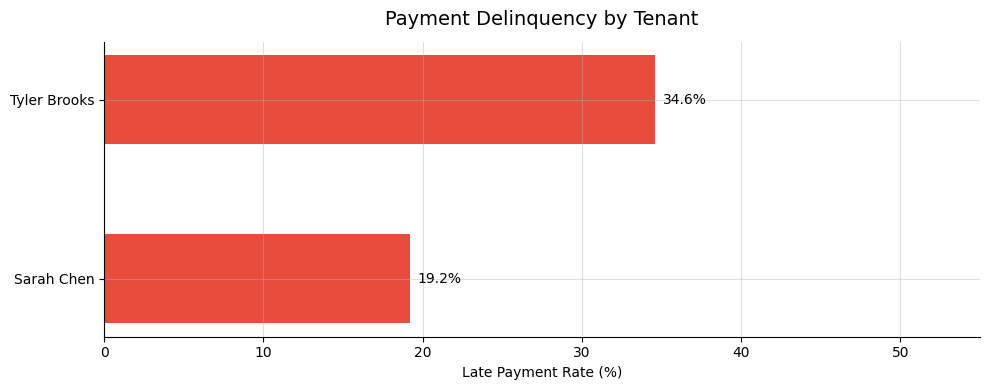

In [18]:
# ── Query 2: Payment Delinquency by Tenant ───────────────────────────
# Late rate per tenant as a horizontal bar chart.
# Horizontal bars work better than vertical here because tenant names
# are long — they read cleanly on the y-axis without rotation.

query = """
    SELECT
        t.first_name || ' ' || t.last_name        AS tenant,
        COUNT(*) FILTER (WHERE p.status = 'late') AS late_payments,
        ROUND(
            COUNT(*) FILTER (WHERE p.status = 'late') * 100.0 / COUNT(*), 1
        )                                          AS late_rate_pct,
        COALESCE(SUM(p.late_fee_charged), 0)       AS late_fees_charged,
        COALESCE(SUM(p.late_fee_collected), 0)     AS late_fees_collected
    FROM payments AS p
    JOIN leases   AS l ON p.lease_id  = l.lease_id
    JOIN tenants  AS t ON l.tenant_id = t.tenant_id
    GROUP BY t.tenant_id, t.first_name, t.last_name
    ORDER BY late_rate_pct DESC
"""

conn = get_connection()
df = pd.read_sql(query, conn)
conn.close()

# Only show tenants who have at least one late payment — the rest are all zeros
# and would just add empty bars that clutter the chart
df_late = df[df["late_payments"] > 0]

fig, ax = plt.subplots(figsize=(10, 4))

bars = ax.barh(df_late["tenant"], df_late["late_rate_pct"], color="#e74c3c", height=0.5)

# Label each bar with the exact percentage so you don't have to squint at the axis
for bar, val in zip(bars, df_late["late_rate_pct"]):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            f"{val}%", va="center", fontsize=10)

ax.set_xlim(0, 55)
ax.set_xlabel("Late Payment Rate (%)")
ax.set_title("Payment Delinquency by Tenant", fontsize=14, pad=12)
ax.invert_yaxis()  # Highest rate at the top

fig.tight_layout()
plt.show()

In [19]:
# ── Query 3: Vacancy Analysis ─────────────────────────────────────────
# Only 2 vacancy gaps in the dataset — a chart would be overkill.
# A clean styled table communicates this better than a bar with 2 bars.
# df.style applies formatting (colours, number format) to the DataFrame
# display without changing the underlying data.

query = """
    WITH lease_gaps AS (
        SELECT
            u.unit_label,
            l.end_date                                        AS lease_end,
            LEAD(l.start_date) OVER (
                PARTITION BY l.unit_id ORDER BY l.start_date
            )                                                 AS next_lease_start,
            l.monthly_rent
        FROM leases AS l
        JOIN units  AS u ON l.unit_id = u.unit_id
    )
    SELECT
        unit_label,
        lease_end,
        next_lease_start,
        (next_lease_start - lease_end)                        AS vacancy_days,
        ROUND((next_lease_start - lease_end) * (monthly_rent / 30.0), 2) AS est_lost_rent
    FROM lease_gaps
    WHERE next_lease_start IS NOT NULL
    ORDER BY vacancy_days DESC
"""

conn = get_connection()
df = pd.read_sql(query, conn)
conn.close()

# Format the table for display — dollar sign on lost rent, no index column
df["est_lost_rent"] = df["est_lost_rent"].apply(lambda x: f"${x:,.2f}")

print("Vacancy Gaps Between Leases\n")
print(df.to_string(index=False))

Vacancy Gaps Between Leases

unit_label  lease_end next_lease_start  vacancy_days est_lost_rent
        R5 2024-05-31       2024-09-01            93     $2,325.00
        R3 2024-10-31       2024-11-01             1        $28.33


C:\Users\kdevu\AppData\Local\Temp\ipykernel_16380\1959522390.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


C:\Users\kdevu\AppData\Local\Temp\ipykernel_16380\3282939329.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


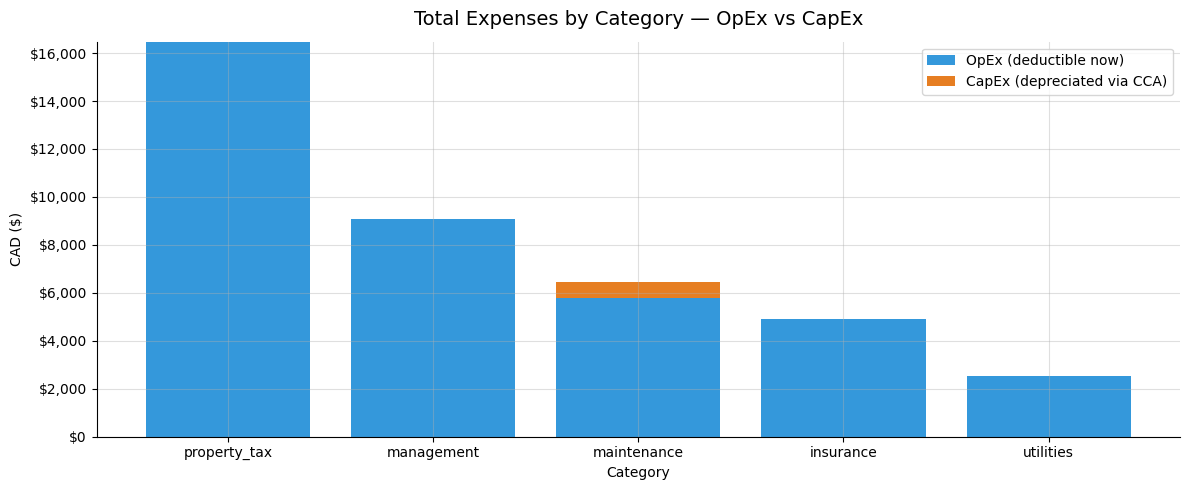

In [20]:
# ── Query 4: Expense Breakdown by Category ────────────────────────────
# Stacked bar chart — each bar is a category, split into OpEx (blue)
# and CapEx (orange). Stacking shows both the total and the composition
# in one view, which is the whole point of the opex/capex distinction.

query = """
    SELECT
        category,
        COALESCE(SUM(amount) FILTER (WHERE expense_class = 'opex'), 0)  AS total_opex,
        COALESCE(SUM(amount) FILTER (WHERE expense_class = 'capex'), 0) AS total_capex
    FROM expenses
    GROUP BY category
    HAVING SUM(amount) > 0
    ORDER BY (
        COALESCE(SUM(amount) FILTER (WHERE expense_class = 'opex'), 0) +
        COALESCE(SUM(amount) FILTER (WHERE expense_class = 'capex'), 0)
    ) DESC
"""

conn = get_connection()
df = pd.read_sql(query, conn)
conn.close()

fig, ax = plt.subplots()

# Bottom bars = OpEx, top bars = CapEx stacked on top
ax.bar(df["category"], df["total_opex"],  label="OpEx (deductible now)", color="#3498db")
ax.bar(df["category"], df["total_capex"], label="CapEx (depreciated via CCA)",
       color="#e67e22", bottom=df["total_opex"])

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))
ax.set_title("Total Expenses by Category — OpEx vs CapEx", fontsize=14, pad=12)
ax.set_xlabel("Category")
ax.set_ylabel("CAD ($)")
ax.legend()

fig.tight_layout()
plt.show()

In [21]:
# ── Query 5: Rent Roll (Current Snapshot) ────────────────────────────
# Active leases only — who is in each unit, what they pay, when they expire.
# Table display makes more sense than a chart here — this is a reference
# document, not a trend. Formatted cleanly for easy reading.

query = """
    SELECT
        u.unit_label,
        t.first_name || ' ' || t.last_name  AS tenant,
        l.monthly_rent,
        l.start_date                         AS lease_start,
        l.end_date                           AS lease_end,
        (CURRENT_DATE - l.start_date) / 30   AS months_tenanted,
        l.security_deposit
    FROM units   AS u
    JOIN leases  AS l ON u.unit_id   = l.unit_id
    JOIN tenants AS t ON l.tenant_id = t.tenant_id
    WHERE l.status = 'active'
    ORDER BY u.unit_label
"""

conn = get_connection()
df = pd.read_sql(query, conn)
conn.close()

# Format dollar columns for readability
df["monthly_rent"]    = df["monthly_rent"].apply(lambda x: f"${x:,.2f}")
df["security_deposit"] = df["security_deposit"].apply(lambda x: f"${x:,.2f}")

print("Current Rent Roll\n")
print(df.to_string(index=False))

Current Rent Roll

unit_label          tenant monthly_rent lease_start lease_end  months_tenanted security_deposit
        R1    James Wilson      $750.00  2024-01-01      None               26          $750.00
        R2      Sarah Chen      $800.00  2024-01-01      None               26          $800.00
        R3    Lucas Nguyen      $875.00  2024-11-01      None               15          $875.00
        R4 Emily Rodriguez      $700.00  2024-01-01      None               26          $700.00
        R5 Olivia Tremblay      $775.00  2024-09-01      None               17          $775.00
        R6     Priya Patel      $900.00  2024-01-01      None               26          $900.00
        R7    Tyler Brooks      $750.00  2024-01-01      None               26          $750.00
        R8   Aisha Mahmoud      $650.00  2024-01-01      None               26          $650.00


C:\Users\kdevu\AppData\Local\Temp\ipykernel_16380\1046154100.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


C:\Users\kdevu\AppData\Local\Temp\ipykernel_16380\1184148618.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


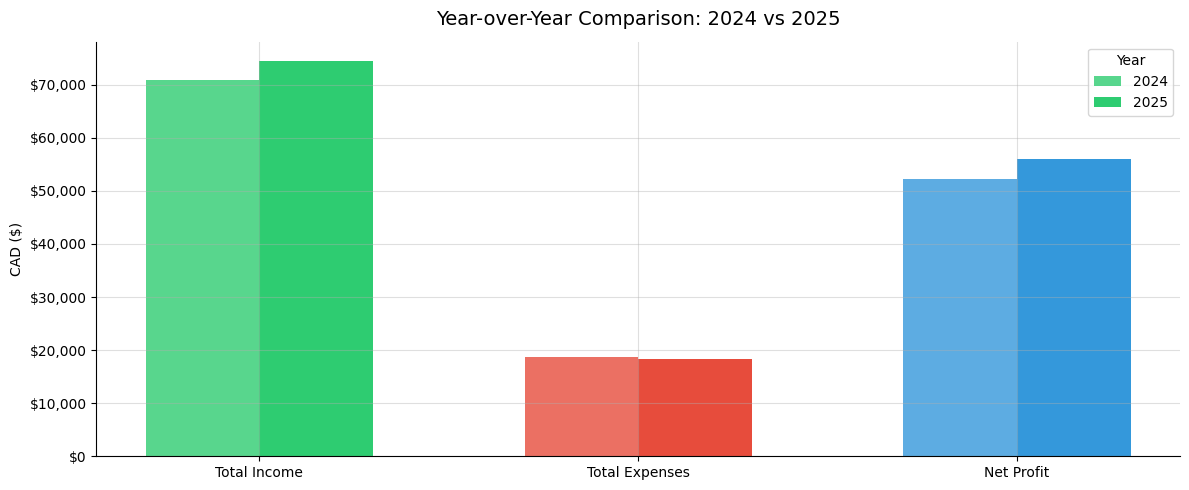

In [22]:
# ── Query 6: Year-over-Year Revenue Comparison ────────────────────────
# Grouped bar chart — 2024 and 2025 side by side for income, expenses,
# and net profit. Grouped bars make year-to-year comparison immediate.

query = """
    WITH yearly_income AS (
        SELECT
            EXTRACT(year FROM payment_date)  AS year,
            SUM(amount)                      AS total_income
        FROM payments
        WHERE status IN ('on_time', 'late')
          AND EXTRACT(year FROM payment_date) IN (2024, 2025)
        GROUP BY 1
    ),
    yearly_expenses AS (
        SELECT
            EXTRACT(year FROM expense_date)  AS year,
            SUM(amount)                      AS total_expenses
        FROM expenses
        WHERE EXTRACT(year FROM expense_date) IN (2024, 2025)
        GROUP BY 1
    )
    SELECT
        i.year,
        i.total_income,
        e.total_expenses,
        i.total_income - e.total_expenses AS net_profit
    FROM yearly_income   AS i
    JOIN yearly_expenses AS e ON i.year = e.year
    ORDER BY i.year
"""

conn = get_connection()
df = pd.read_sql(query, conn)
conn.close()

# ── Chart ─────────────────────────────────────────────────────────────
# numpy helps position the grouped bars side by side.
# Each metric (income, expenses, net profit) gets its own group of 2 bars.
import numpy as np

metrics = ["total_income", "total_expenses", "net_profit"]
labels  = ["Total Income", "Total Expenses", "Net Profit"]
colors  = ["#2ecc71", "#e74c3c", "#3498db"]
x       = np.arange(len(labels))   # [0, 1, 2] — one position per metric
width   = 0.3                       # width of each individual bar

fig, ax = plt.subplots()

for i, (year_row, offset) in enumerate(zip(df.itertuples(), [-width/2, width/2])):
    vals = [getattr(year_row, m) for m in metrics]
    ax.bar(x + offset, vals, width, label=str(int(year_row.year)),
           color=[c + ("cc" if i == 0 else "ff") for c in colors])

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f"${v:,.0f}"))
ax.set_title("Year-over-Year Comparison: 2024 vs 2025", fontsize=14, pad=12)
ax.set_ylabel("CAD ($)")
ax.legend(title="Year")

fig.tight_layout()
plt.show()